In [1]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

from tqdm.auto import tqdm



In [2]:
import torchvision
import torchvision.models.detection as detection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
    transform = [transforms.ToTensor()]
    return transforms.Compose(transform)


In [3]:
dataset = torchvision.datasets.Kitti(root='../data')

In [4]:
print(len(dataset))

7481


In [5]:
# mamnually find all the labels in the dataset correctly
labels = {}
for i in range(len(dataset)):
    img, target = dataset[i]
    for t in target:
        if t['type'] not in labels:
            labels[t['type'] ] = 1
        else:
            labels[t['type'] ] += 1


print(labels)

{'Car': 28742, 'DontCare': 11295, 'Van': 2914, 'Cyclist': 1627, 'Misc': 973, 'Truck': 1094, 'Pedestrian': 4487, 'Tram': 511, 'Person_sitting': 222}


In [6]:
class Kitti(torchvision.datasets.Kitti):
    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        # Adding +1 to all indices to reserve 0 for background
        labels = [1 + ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare'].index(t['type']) for t in target if t['type'] in ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']]
        boxes = [t['bbox'] for t in target if t['type'] in ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']]
        
        target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4),
                  'labels': torch.as_tensor(labels, dtype=torch.int64)}
        return image, target

dataset = Kitti(root='../data', transform=get_transform(train=True), download=True)
dataset_test = Kitti(root='../data', transform=get_transform(train=False), download=True)


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

batch_size = 4

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=0,
  collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=batch_size,
  shuffle=False,
  num_workers=0,
  collate_fn=utils.collate_fn,
)

In [7]:
print(len(dataset), len(dataset_test))

5985 1496


In [8]:
# Check if GPU is available
torch.cuda.empty_cache()
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  - {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  - Memory Total: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
        print(f"  - Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  - Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
else:
    print("No GPU is available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3070
  - 0.00 GB
  - Memory Cached: 0.00 GB
  - Memory Total: 7.79 GB
  - Compute Capability: (8, 6)
  - Multiprocessors: 46


In [9]:
def get_object_detection_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=False)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#   for param in model.backbone.parameters():
#         param.requires_grad = False
        
  return model

In [10]:
import pprint as pp

image, target = dataset[0]
print(image)
print(type(target))
pp.pprint(target)


print("data loader part")
for images, targets in data_loader:
    print(len(images))
    print(images[0].shape)
    print(type(targets))
    pp.pprint(targets)
    break


tensor([[[0.5569, 0.5569, 0.5725,  ..., 1.0000, 1.0000, 1.0000],
         [0.5569, 0.5569, 0.5725,  ..., 1.0000, 1.0000, 1.0000],
         [0.5569, 0.5569, 0.5647,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4196, 0.4275, 0.4314,  ..., 0.0549, 0.0588, 0.0588],
         [0.4275, 0.4275, 0.4314,  ..., 0.0549, 0.0588, 0.0588],
         [0.4353, 0.4314, 0.4627,  ..., 0.0510, 0.0471, 0.0471]],

        [[0.8627, 0.8627, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
         [0.8588, 0.8549, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
         [0.8510, 0.8471, 0.8588,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.3922, 0.4118, 0.4431,  ..., 0.0588, 0.0588, 0.0588],
         [0.3922, 0.4157, 0.4471,  ..., 0.0510, 0.0510, 0.0510],
         [0.3961, 0.4196, 0.4431,  ..., 0.0471, 0.0471, 0.0471]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [11]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


# Define the list of classes
class_list = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

num_classes = len(class_list) # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

cuda


In [12]:
# # Function to evaluate the model
# def evaluate_model(model, data_loader, device):
#     model.eval()  # Set the model to evaluation mode
#     eval_results = []
#     with torch.no_grad():
#         for images, targets in tqdm(data_loader):
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             outputs = model(images)
#             eval_results.append((outputs, targets))
#     return eval_results

# # Load the baseline model (pre-trained, unmodified)
# baseline_model = get_object_detection_model(num_classes)
# baseline_model.to(device)

# # Evaluate the baseline model
# baseline_eval_results = evaluate_model(baseline_model, data_loader_test, device)

# torch.cuda.empty_cache()

In [13]:
# # training for 5 epochs
# num_epochs = 5

# model_save_path = './models/faster_rcnn_kitti.pth'

# # Training loop
# num_epochs = 5
# for epoch in range(num_epochs):
#     train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#     lr_scheduler.step()

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_save_path)

In [14]:
torch.cuda.empty_cache()

In [15]:
import wandb

# Login to WandB (only needed if you haven't configured automatic login)
wandb.login()

num_epochs = 5

# Initialize a new WandB run
wandb.init(project="portalcut",
            entity='231n-augmentation', 
            notes="2024-05-30-kitti-test1-fasterrcnn_resnet50_fpn_v2_scratch_50ep",
            
            config={
                "learning_rate": 0.005,
                "epochs": num_epochs,
                "batch_size": batch_size,
                "optimizer": "SGD",
                "momentum": 0.9,
                "weight_decay": 0.0005,
                "lr_scheduler": "StepLR",
                "step_size": 3,
                "gamma": 0.1
            })
config = wandb.config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sazzadi14. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: sazzadi14 (231n-augmentation). Use `wandb login --relogin` to force relogin


In [16]:
# training for 5 epochs
import math
import sys
import time
import utils

scaler = None  # Define the "scaler" variable

model_save_path = './models/2024-05-30-kitti-test1-fasterrcnn_resnet50_fpn_v2_scratch_50ep.pth'
print_freq = 10
# Training loop

# Assume we have an existing setup
for epoch in range(num_epochs):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"
    start_time = time.time()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "loss": loss_value,
            "learning_rate": optimizer.param_groups[0]["lr"]
        })
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # After each epoch
    # lr_scheduler.step()



# wandb.log_artifact(model)
torch.save(model.state_dict(), model_save_path)

# model.to_onnx()
# wandb.save("model.onnx")


# Finish WandB run
wandb.finish()

Epoch: [0]  [   0/1497]  eta: 0:29:32  lr: 0.000010  loss: 3.1129 (3.1129)  loss_classifier: 2.2351 (2.2351)  loss_box_reg: 0.0663 (0.0663)  loss_objectness: 0.6963 (0.6963)  loss_rpn_box_reg: 0.1152 (0.1152)  time: 1.1839  data: 0.0391  max mem: 6310
Epoch: [0]  [  10/1497]  eta: 0:14:03  lr: 0.000060  loss: 3.0516 (3.0345)  loss_classifier: 2.1755 (2.1357)  loss_box_reg: 0.0718 (0.0718)  loss_objectness: 0.6963 (0.6962)  loss_rpn_box_reg: 0.1152 (0.1308)  time: 0.5671  data: 0.0358  max mem: 6663
Epoch: [0]  [  20/1497]  eta: 0:13:11  lr: 0.000110  loss: 2.6746 (2.6571)  loss_classifier: 1.8393 (1.7775)  loss_box_reg: 0.0718 (0.0724)  loss_objectness: 0.6958 (0.6959)  loss_rpn_box_reg: 0.0648 (0.1113)  time: 0.5035  data: 0.0342  max mem: 6663
Epoch: [0]  [  30/1497]  eta: 0:12:49  lr: 0.000160  loss: 1.7304 (2.2759)  loss_classifier: 0.7788 (1.3643)  loss_box_reg: 0.0632 (0.0670)  loss_objectness: 0.6952 (0.6955)  loss_rpn_box_reg: 0.1210 (0.1491)  time: 0.5012  data: 0.0329  max me

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
learning_rate,▁▂▃▅▆███████████████████████████████████
loss,█▄▂▄▄▂▄▇▄▁▅▄▆▂▆▅▂▃▄▄▄▃▆▄▂▅▄▄▃▂▂▁▃▄▂▃▇▁▂▃
epoch,4
learning_rate,0.005
loss,0.53924


In [17]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  - {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  - Memory Total: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
        print(f"  - Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  - Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
else:
    print("No GPU is available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3070
  - 0.52 GB
  - Memory Cached: 7.05 GB
  - Memory Total: 7.79 GB
  - Compute Capability: (8, 6)
  - Multiprocessors: 46


In [18]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [19]:
dataset_test[0]

(tensor([[[0.0706, 0.0706, 0.1098,  ..., 0.1529, 0.1608, 0.1647],
          [0.0588, 0.0588, 0.0588,  ..., 0.1686, 0.1725, 0.1686],
          [0.0824, 0.0902, 0.0784,  ..., 0.1569, 0.1608, 0.1451],
          ...,
          [0.0667, 0.0627, 0.0588,  ..., 0.0902, 0.0824, 0.0824],
          [0.0353, 0.0392, 0.0471,  ..., 0.0980, 0.0863, 0.0824],
          [0.0471, 0.0510, 0.0510,  ..., 0.1098, 0.0902, 0.0784]],
 
         [[0.0941, 0.0863, 0.1137,  ..., 0.1294, 0.1059, 0.0784],
          [0.0941, 0.0863, 0.0745,  ..., 0.1255, 0.1059, 0.0745],
          [0.0745, 0.0941, 0.0941,  ..., 0.1216, 0.0980, 0.0667],
          ...,
          [0.0824, 0.0824, 0.0745,  ..., 0.0980, 0.0980, 0.0980],
          [0.0784, 0.0667, 0.0667,  ..., 0.1059, 0.1059, 0.0980],
          [0.0824, 0.0745, 0.0706,  ..., 0.1216, 0.1529, 0.1647]],
 
         [[0.0706, 0.0824, 0.0824,  ..., 0.1137, 0.0980, 0.0549],
          [0.0667, 0.0667, 0.0667,  ..., 0.1059, 0.0902, 0.0588],
          [0.0667, 0.0667, 0.0627,  ...,

4
4
4
4
4
4
4
9
4
9
1
4
4
9
4
4
4
4
9
4
4
9
4
9
9
9
4
9
9
4
9
9
4
2
6
4
4
3
4
4
6
4
9
4
9
9
5
1
4
9
9
7
9
9
4
9
9
9
9
4
4
8
5
9
9
6
9
4
4
5
4
4
1
4
4
9
9
4
4
9
1
7
9
9
6
2
6
4
3
4
4
1
9
4
4
1
1
9
9
6


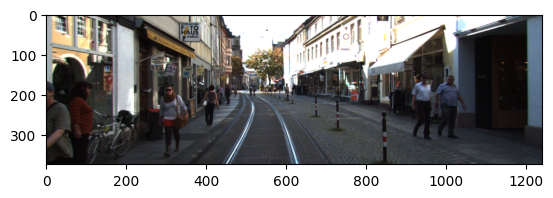

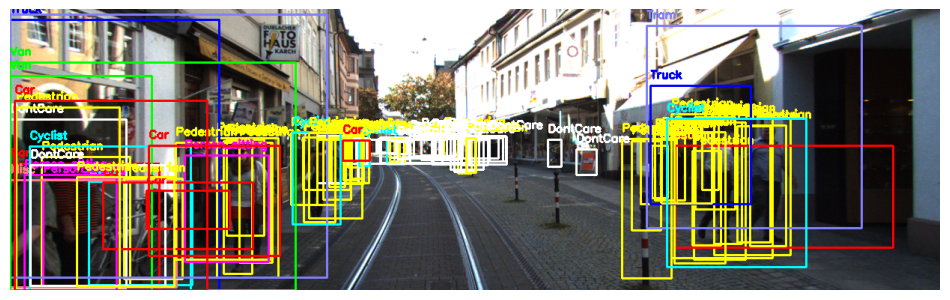

In [20]:
# Write the code that saves up the model from the internet and tests it
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np

image = dataset_test[5][0]
# Load the model
model.load_state_dict(torch.load(model_save_path))

# Ensure your model is on the GPU
model = model.to('cuda')

# Move the input tensor to the GPU
input_tensor = image.unsqueeze(0).to('cuda')


model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    predictions = model(input_tensor)


import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_with_boxes(image, boxes, labels, label_names):
    # Convert tensor image to numpy array
    image = image.cpu().numpy().transpose((1, 2, 0))
    # Scale the image's pixel values to [0, 255]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
    # Convert the image to CPU and NumPy format for plotting


    # Define colors for different classes
    colors = {
        'Car': (255, 0, 0), 'Van': (0, 255, 0), 'Truck': (0, 0, 255),
        'Pedestrian': (255, 255, 0), 'Person_sitting': (255, 0, 255), 'Cyclist': (0, 255, 255),
        'Tram': (127, 127, 255), 'Misc': (255, 127, 127), "Don'tCare": (127, 127, 127)
    }

    # Draw boxes and labels
    for box, label in zip(boxes, labels):
        box = box.cpu().numpy().astype(int)
        label = int(label.cpu())
        box = box.astype(int)
        print(label)
        label_text = label_names[label]
        color = colors.get(label_text, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label
        cv2.putText(image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

# Sample call to the function

target = predictions[0]
# image = dataset[0][0]
plt.imshow(image.permute(1, 2, 0))
# This assumes `image` is a tensor from the dataset, `boxes` is a tensor of bounding boxes, and `labels` is a tensor of label indices
visualize_image_with_boxes(image, target['boxes'], target['labels'], label_names)


In [21]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.ops import box_iou
from collections import defaultdict

# Load the model
model.load_state_dict(torch.load(model_save_path))
model = model.to('cuda')
model.eval()

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

def compute_iou(boxes1, boxes2):
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.tensor([]).to(boxes1.device)
    boxes1 = boxes1.to('cuda')
    boxes2 = boxes2.to('cuda')
    ious = box_iou(boxes1, boxes2)
    return ious

def evaluate_model(model, dataset, label_names, iou_threshold=0.5):
    all_true_boxes = []
    all_pred_boxes = []
    all_true_labels = []
    all_pred_labels = []

    for idx in range(len(dataset)):
        image, target = dataset[idx]
        input_tensor = image.unsqueeze(0).to('cuda')
        
        with torch.no_grad():
            predictions = model(input_tensor)[0]
        
        true_boxes = target['boxes'].to('cuda')
        true_labels = target['labels'].to('cuda')
        pred_boxes = predictions['boxes'].to('cuda')
        pred_labels = predictions['labels'].to('cuda')

        all_true_boxes.append(true_boxes)
        all_pred_boxes.append(pred_boxes)
        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    iou_scores = []
    for true_boxes, pred_boxes in zip(all_true_boxes, all_pred_boxes):
        iou_scores.append(compute_iou(true_boxes, pred_boxes))

    mean_iou = torch.mean(torch.stack([torch.mean(iou) for iou in iou_scores if iou.numel() > 0]))
    print(f"Mean IoU: {mean_iou:.4f}")

    # Compute mAP (mean Average Precision)
    aps = []
    for i, label_name in enumerate(label_names):
        if label_name == "Background":
            continue
        
        true_positives = []
        false_positives = []
        num_gt = 0

        for true_boxes, true_labels, pred_boxes, pred_labels in zip(all_true_boxes, all_true_labels, all_pred_boxes, all_pred_labels):
            gt_boxes = true_boxes[true_labels == i]
            pred_boxes = pred_boxes[pred_labels == i]
            num_gt += len(gt_boxes)

            if len(pred_boxes) == 0:
                continue
            
            ious = compute_iou(gt_boxes, pred_boxes)
            if ious.numel() == 0:
                continue
            true_positive = ious.max(dim=0)[0] > iou_threshold
            false_positive = ~true_positive

            true_positives.extend(true_positive.cpu().numpy())
            false_positives.extend(false_positive.cpu().numpy())
        
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recalls = tp_cumsum / (num_gt + 1e-6)

        ap = np.trapz(precisions, recalls)
        aps.append(ap)

        print(f"AP for {label_name}: {ap:.4f}")

    mAP = np.mean(aps)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Example usage
evaluate_model(model, dataset_test, label_names)


Mean IoU: 0.0859
AP for Car: 0.4142
AP for Van: 0.4119
AP for Truck: 0.5177
AP for Pedestrian: 0.2458
AP for Person_sitting: 0.2439
AP for Cyclist: 0.3130
AP for Tram: 0.5164
AP for Misc: 0.2744
AP for DontCare: 0.1010
Mean Average Precision (mAP): 0.3376


In [22]:
evaluate_model(model, dataset, label_names)

Mean IoU: 0.0871
AP for Car: 0.4297
AP for Van: 0.4308
AP for Truck: 0.4742
AP for Pedestrian: 0.2567
AP for Person_sitting: 0.3449
AP for Cyclist: 0.3604
AP for Tram: 0.5450
AP for Misc: 0.3291
AP for DontCare: 0.1180
Mean Average Precision (mAP): 0.3654
